In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
from collections import deque
import random

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.compat.v1.reset_default_graph()
        tf.compat.v1.disable_eager_execution()
        self.X = tf.compat.v1.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.compat.v1.placeholder(tf.float32, (None))
        self.REWARD = tf.compat.v1.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(input=self.ACTION)[0]
        
        with tf.compat.v1.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.compat.v1.layers.dense(state_action, 32, activation=tf.nn.relu)
            self.curiosity_logits = tf.compat.v1.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(input_tensor=tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.compat.v1.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(input_tensor=self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.compat.v1.variable_scope("q_model"):
            with tf.compat.v1.variable_scope("eval_net"):
                x_action = tf.compat.v1.layers.dense(self.X, 128, tf.nn.relu)
                self.logits = tf.compat.v1.layers.dense(x_action, self.OUTPUT_SIZE)
            
            with tf.compat.v1.variable_scope("target_net"):
                y_action = tf.compat.v1.layers.dense(self.Y, 128, tf.nn.relu)
                y_q = tf.compat.v1.layers.dense(y_action, self.OUTPUT_SIZE)
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(input_tensor=y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.compat.v1.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.compat.v1.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.compat.v1.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\joshu\AppData\Local\Temp\ipykernel_16584\1919226857.py:38: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.compat.v1.layers.dense(state_action, 32, activation=tf.nn.relu)
C:\Users\joshu\AppData\Local\Temp\ipykernel_16584\1919226857.py:39: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.curiosity_logits = tf.compat.v1.layers.dense(feed, self.state_size)
C:\Users\joshu\AppData\Local\Temp\ipykernel_16584\1919226857.py:49: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x_action = tf.compat.v1.layers.dense(self.X, 128, tf.nn.relu)
C:\Users\joshu\AppData\Local\Temp\ipykernel_16584\1919226857.py:50: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` in

epoch: 10, total rewards: 326.515074.3, cost: 106119.531250, total money: 4403.605040
epoch: 20, total rewards: 693.950133.3, cost: 4263721.000000, total money: 3921.080137
epoch: 30, total rewards: 787.930056.3, cost: 66805.906250, total money: 3898.710023
epoch: 40, total rewards: 1500.645140.3, cost: 1214621.000000, total money: 6573.125120
epoch: 50, total rewards: 1284.670046.3, cost: 19500.328125, total money: 1575.660035
epoch: 60, total rewards: 1749.374754.3, cost: 848994.625000, total money: 7755.434750
epoch: 70, total rewards: 1469.549618.3, cost: 46228.218750, total money: 1682.739619
epoch: 80, total rewards: 1511.320062.3, cost: 677447.625000, total money: 10538.760064
epoch: 90, total rewards: 1046.110234.3, cost: 1304294.375000, total money: 11046.110234
epoch: 100, total rewards: 1427.940242.3, cost: 1450586.625000, total money: 106.970148
epoch: 110, total rewards: 465.660040.3, cost: 521737.937500, total money: 10465.660040
epoch: 120, total rewards: 1566.360283.3, 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 2: buy 1 unit at price 762.020020, total balance 9231.409973
day 5, sell 1 unit at price 785.309998, investment 3.056347 %, total balance 10016.719971,
day 8: buy 1 unit at price 736.080017, total balance 9280.639954
day 10: buy 1 unit at price 764.479980, total balance 8516.159974
day 11: buy 1 unit at price 771.229980, total balance 7744.929994
day 12, sell 1 unit at price 760.539978, investment 3.323003 %, total balance 8505.469972,
day 13, sell 1 unit at price 769.200012, investment 0.617417 %, total balance 9274.669984,
day 14, sell 1 unit at price 768.270020, investment -0.383797 %, total balance 10042.940004,
day 15: buy 1 unit at price 760.989990, total balance 9281.950014
day 16: buy 1 unit at price 761.679993, total balance 8520.270021
day 17: buy 1 unit at price 768.239990, total balance 7752.030031
day 18, sell 1 uni

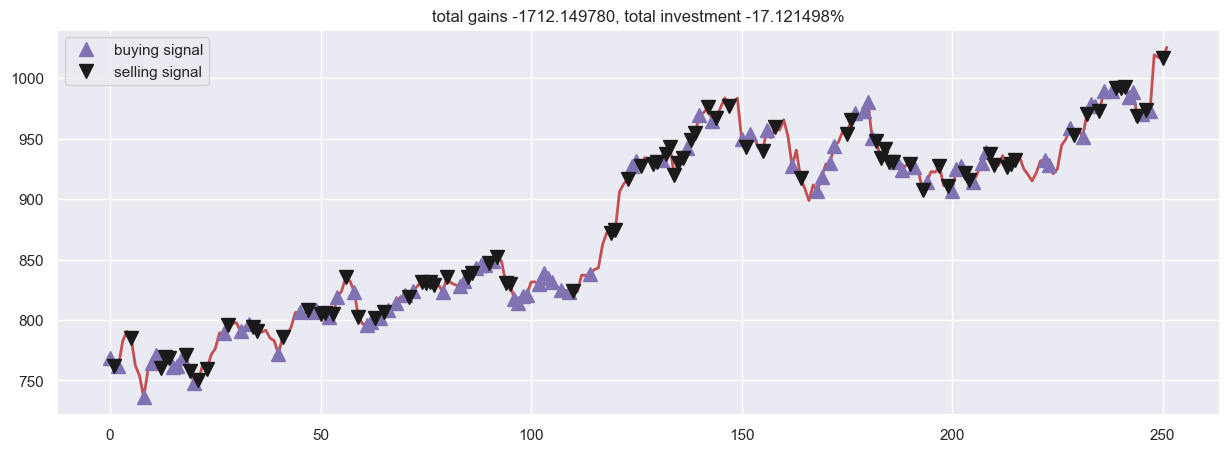

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()